In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
## update data
def filter_df(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [4]:
#linear regression for males

In [5]:
# arrange data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]
m_data = data_all.query('age<100')

In [6]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_females_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]
f_data = data_all.query('age<100')

In [7]:
# use only common ages
f_ages = f_data.index.get_level_values('age').unique().to_numpy()
m_ages = m_data.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
m_data = m_data.loc[m_data.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_data.loc[f_data.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)
data=pd.concat([m_data,f_data])

In [8]:
# look at syllable usage diff male and females according to actual age
#m_data = m_psd.query('age < 80').copy()
x = m_data.to_numpy()
x_log = np.log(x + 1e-6)
x = (x_log - x_log.mean(axis=0, keepdims=True)) / x_log.std(axis=0, keepdims=True) #z-score
y = m_data.index.get_level_values('age')

# run GLM
alpha=0.01
lr = ElasticNet(alpha=alpha)
lr.fit(x, y)
## feature importance
m_importance = lr.coef_

# run for a few shffules
m_sh=[]
it = 1000
for i in range(it):
    ysh= np.random.permutation(y)
    lr.fit(x, ysh)
    m_sh.append(lr.coef_)
msh = np.mean(m_sh, axis=0)

# normalize to shuffle:
m_importance = m_importance - msh
scalar = MinMaxScaler(feature_range=(-1, 1))
m_importance = scalar.fit_transform(m_importance.reshape(-1, 1)).flatten()

In [9]:
# look at syllable usage diff male and females according to actual age
x = f_data.to_numpy()
x_log = np.log(x + 1e-6)
x = (x_log - x_log.mean(axis=0, keepdims=True)) / x_log.std(axis=0, keepdims=True) #z-score
y = f_data.index.get_level_values('age')

# run GLM
lr = ElasticNet(alpha=alpha)
lr.fit(x, y)
## feature importance
f_importance = lr.coef_

# run for a few shffules
f_sh=[]
it = 100
for i in range(it):
    ysh= np.random.permutation(y)
    lr.fit(x, ysh)
    f_sh.append(lr.coef_)
fsh = np.mean(f_sh, axis=0)

# normalize to shuffle:
f_importance = f_importance - fsh
scalar = MinMaxScaler(feature_range=(-1, 1))
f_importance = scalar.fit_transform(f_importance.reshape(-1, 1)).flatten()

In [10]:
df=pd.DataFrame()
df['coef'] = np.concatenate([m_importance, f_importance])
df['sex'] = ['m']*len(m_importance) + ['f']*len(f_importance)
df['syll'] = list(m_data.columns.to_numpy()) + list(f_data.columns.to_numpy())

In [11]:
# plot the diff:
diff= abs(df[df.sex=='m'].coef.values) - abs(df[df.sex=='f'].coef.values)
scalar = MinMaxScaler(feature_range=(-1, 1))
new_diff = scalar.fit_transform(diff.reshape(-1, 1))

df_diff=pd.DataFrame()
df_diff['diff'] = new_diff.flatten()
df_diff['syll'] = m_data.columns.to_numpy()
df_diff['sex'] = new_diff>0

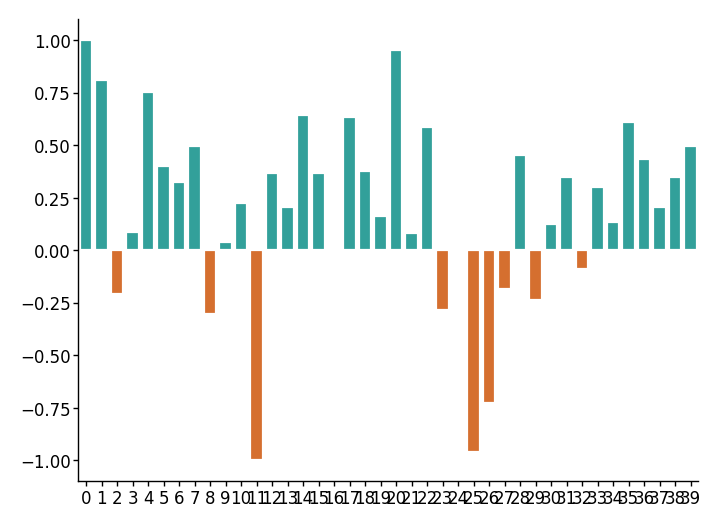

In [12]:
# plot the diff:
diff= abs(df[df.sex=='m'].coef.values) - abs(df[df.sex=='f'].coef.values)
scalar = MinMaxScaler(feature_range=(-1, 1))
new_diff = scalar.fit_transform(diff.reshape(-1, 1))

# colors
s=np.array(m_data.columns.astype(int))
colors = np.array(['#20B2AA' if value > 0 else '#f16913' for value in new_diff])
colors=colors[s]

fig, ax = plt.subplots()
fig.set_size_inches(4,3)
sns.barplot(x=list(m_data.columns.to_numpy()) , y=new_diff.flatten(), palette=colors)

sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_syll_importance_aging_bars.pdf')

In [13]:
# trying to z-score?
from scipy.stats import zscore
combined_df = pd.concat([f_data, m_data], ignore_index=True)

# Identify the columns to z-score (excluding non-numeric columns like 'age')
columns_to_zscore = combined_df.select_dtypes(include='number').columns

# Z-score the values in the combined DataFrame
combined_df[columns_to_zscore] = zscore(combined_df[columns_to_zscore])

# Split the combined DataFrame back into 'f' and 'm'
f_zscored = combined_df.iloc[:len(f_data)]
m_zscored = combined_df.iloc[len(m_data):]

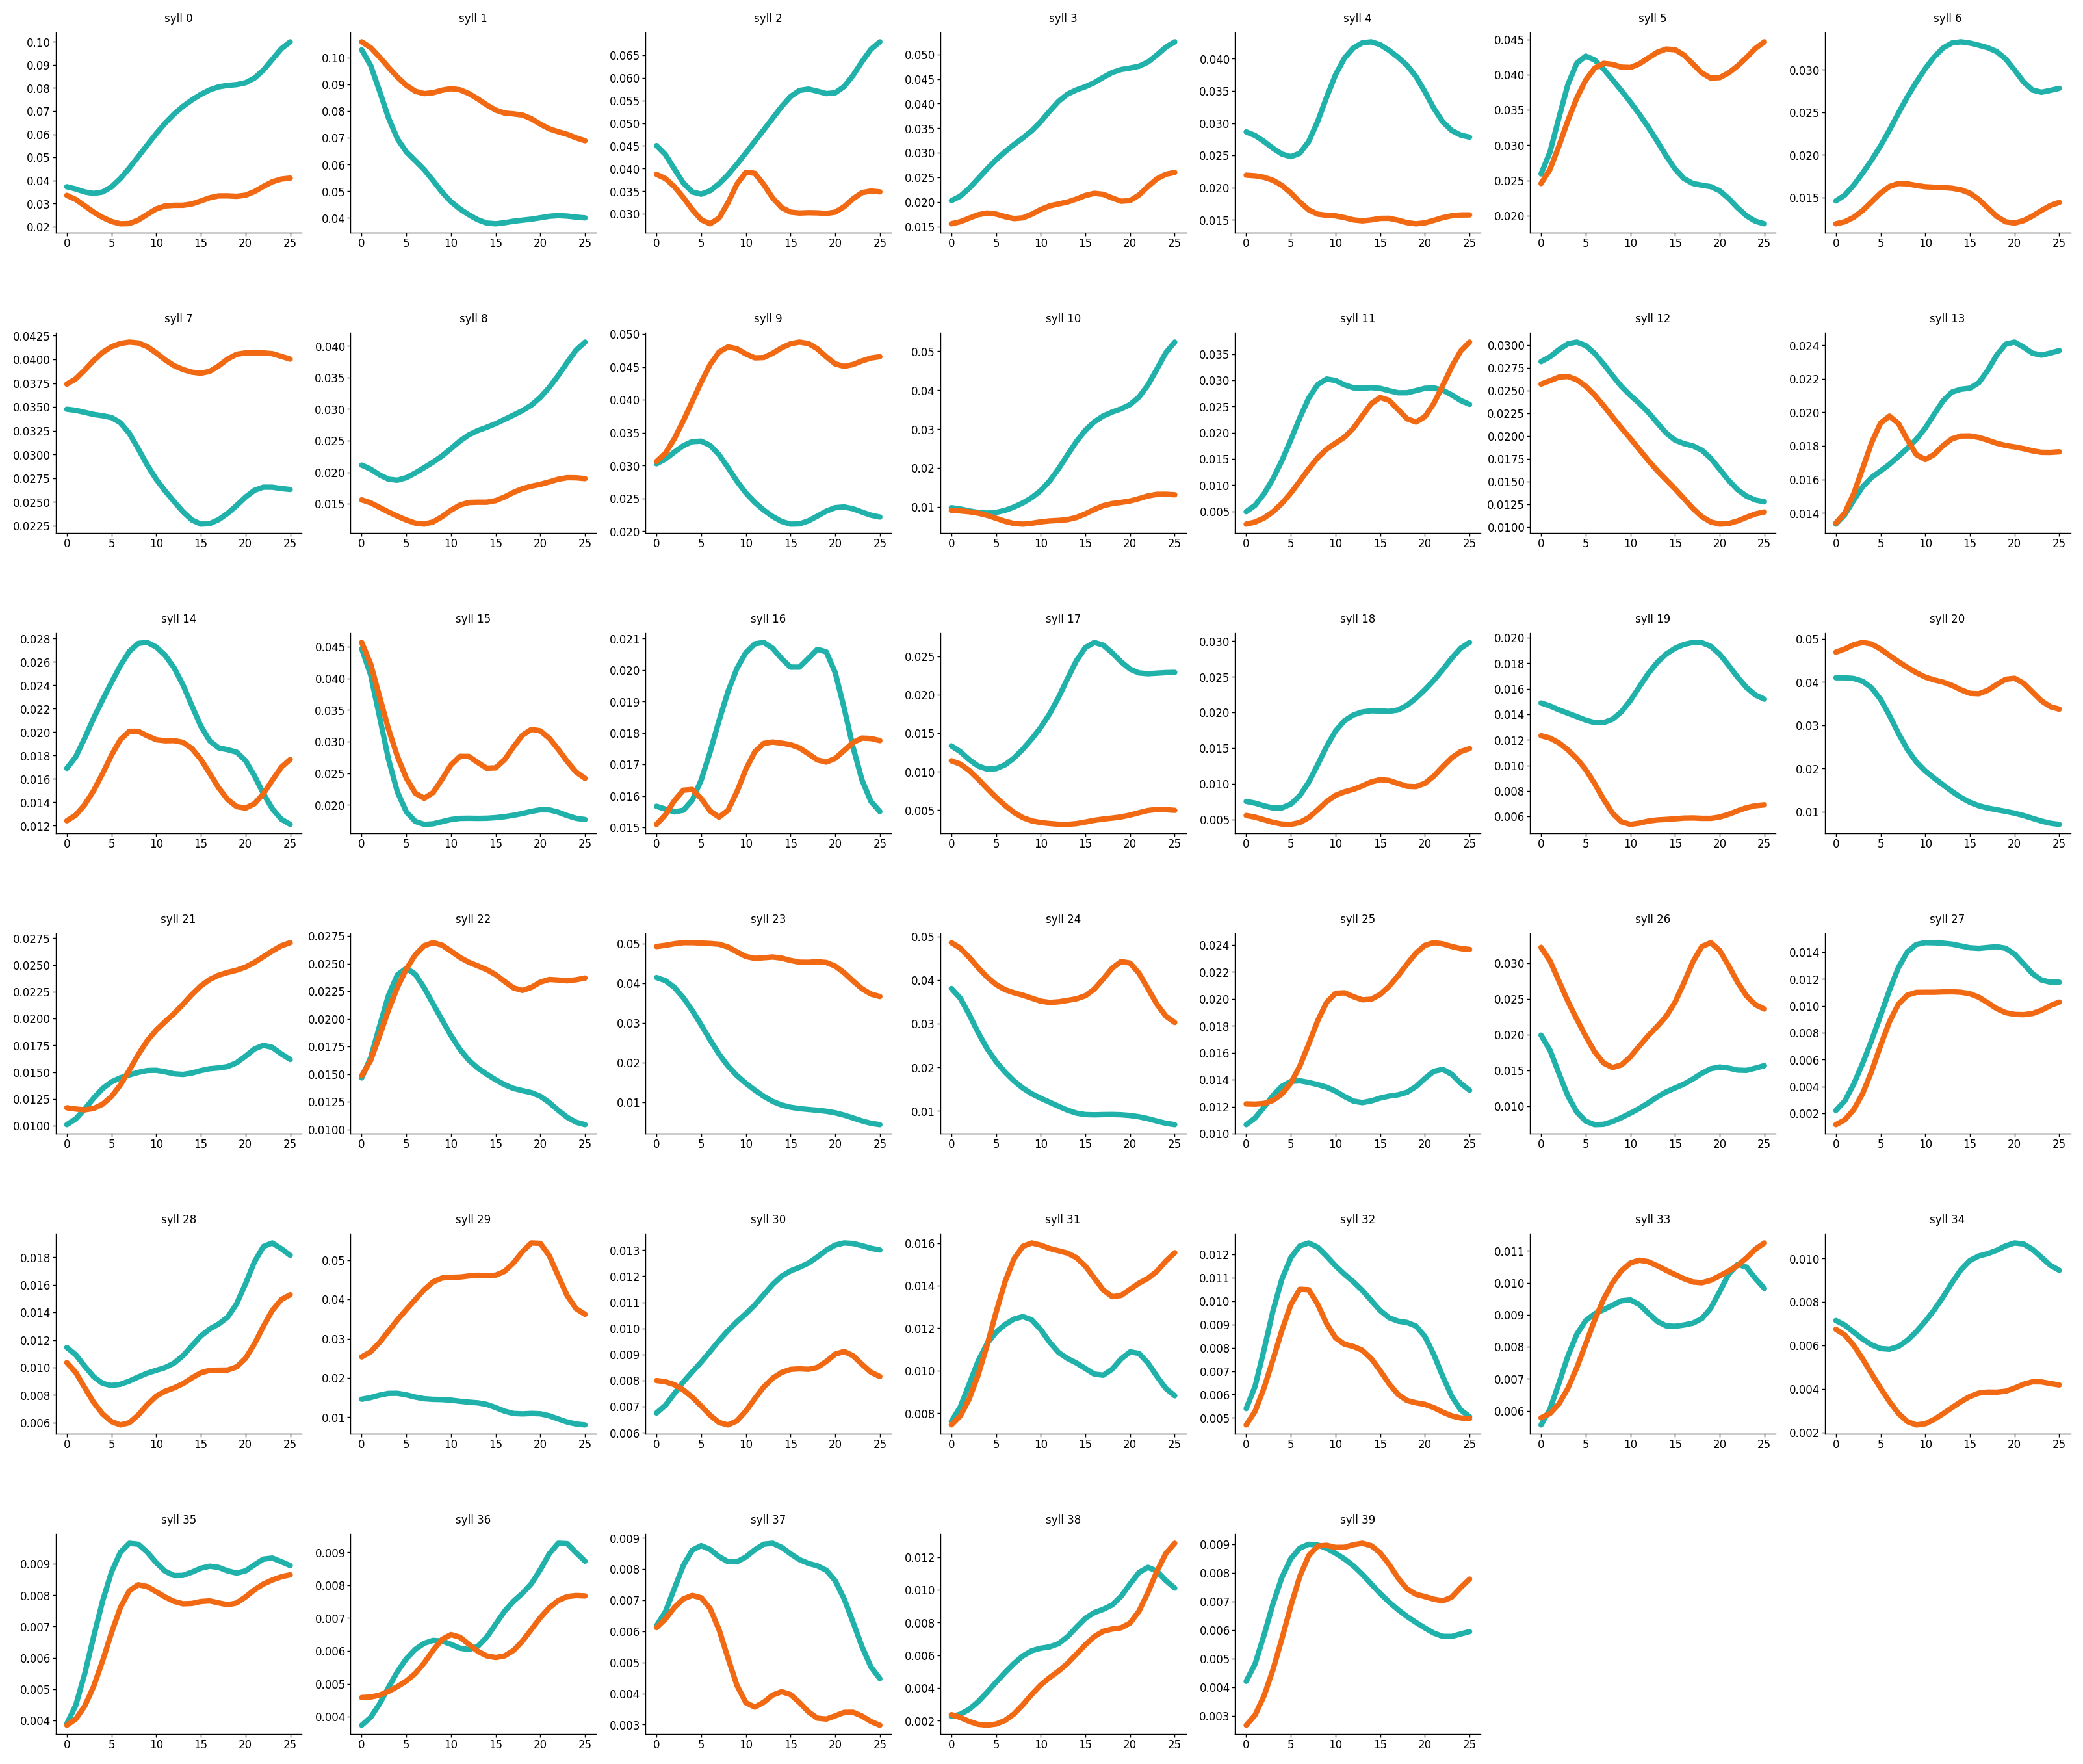

In [14]:
from scipy.ndimage import gaussian_filter1d

# plot some example syllbles:
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
n=0
syll=range(40)
for s in syll:
    m = m_data.groupby('age').mean()[s].values
    f= f_data.groupby('age').mean()[s].values
    ax = plt.subplot(7, 7, n + 1)
    #plt.plot(m, color='purple', lw=3)
    #plt.plot(f, color='#d94801',lw=3)
    plt.plot(gaussian_filter1d(m,2), color='#20B2AA', lw=3)
    plt.plot(gaussian_filter1d(f,2), color='#f16913',lw=3)
    ax.set_title('syll ' + str(s))
    #ax.set_ylim([0, 0.08])
    sns.despine()
    n=n+1
#fig.savefig(c.dana_save_path / "simons"/ 'fvm_important_female_syll_example.pdf')

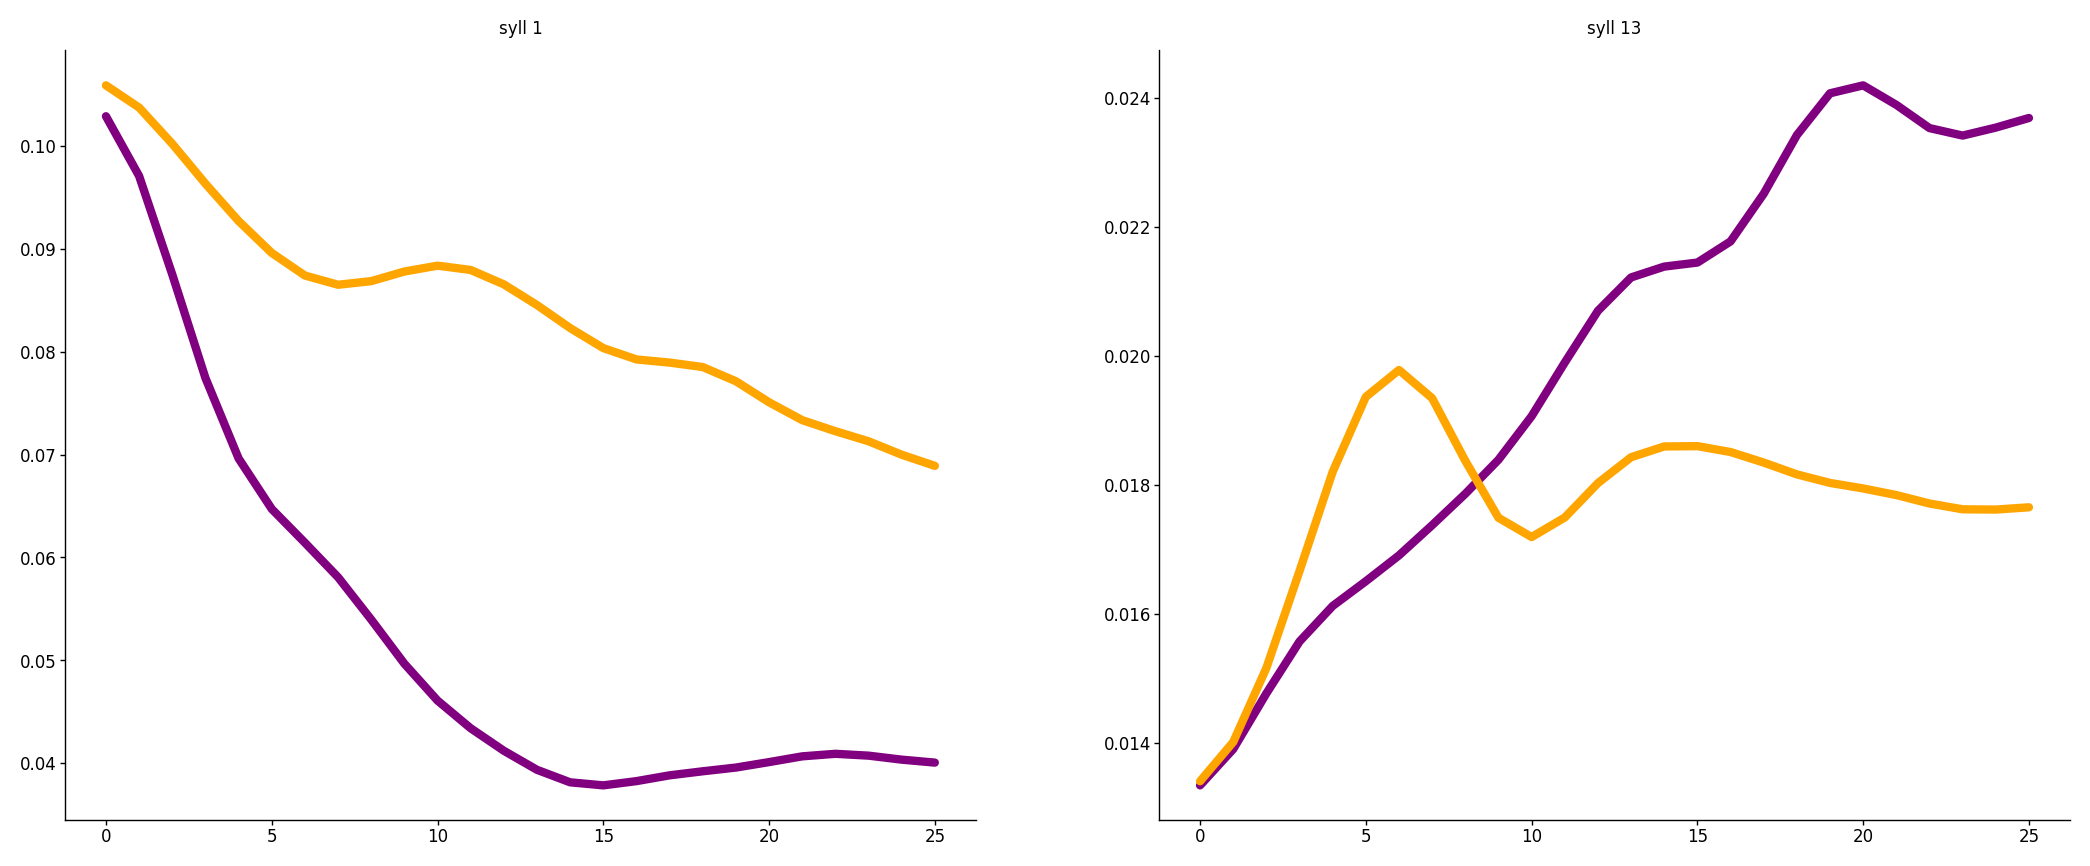

In [15]:
# plot some example syllbles:
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
n=0
syll=[1,13,]
for s in syll:
    m = m_data.groupby('age').mean()[s].values
    f= f_data.groupby('age').mean()[s].values
    ax = plt.subplot(3, 3, n + 1)
    plt.plot(gaussian_filter1d(m,2), color='purple', lw=3)
    plt.plot(gaussian_filter1d(f,2), color='orange',lw=3)
    ax.set_title('syll ' + str(s))
    #ax.set_ylim([0, 0.08])
    sns.despine()
    n=n+1
#fig.savefig(c.dana_save_path / "simons"/ 'fvm_important_male_example.pdf')